- Wybrać zbiór danych
- Przygotować dane do analizy (jeśli są jakieś dane brakujące zastąpić na razie np. wartością średnią, starać się, żeby cechy miały wartości liczbowe, jeśli jakiś zbiór będzie miał cechę textową, można wyrzucić lub zamienić np. one-hot-encoding)
- Zbudować 2-4 modele uczenie maszynowego
- Dla każdego z modeli zastosować 2 metody wyjaśnienia lokalnego (np. Lime/Shap)
- Dla kazdego podobnie metodę wyjaśnienia globalnego (np. feature importance, PDP)
- Przygotować raport porównawczy (czy wyjaśnienia są spójne, które dostarczają ciekawych wyników, czy to zbiega z Państwa interpretacją, jakieś różnice etc)
- Proszę o dogłębne przedstawienie i porównenie tego co wyżej (opis, wykresy)

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression


from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

import shap
import lime.lime_tabular
from sklearn.inspection import PartialDependenceDisplay

In [11]:
# datasets

# Classification
data_diabetes = pd.read_csv("diabetes.csv")

X_cls = data_diabetes.drop("Outcome", axis=1)
y_cls = data_diabetes["Outcome"]

# split data set to train/test sets
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

# standarize data
scaler_cls = StandardScaler()
X_train_cls = scaler_cls.fit_transform(X_train_cls)
X_test_cls = scaler_cls.transform(X_test_cls)

print(f"Zbiór danych o cukrzycy: {X_cls.shape[0]} próbek, {X_cls.shape[1]} cech.")
print(f"Rozkład klas: {np.bincount(y_cls)}")


Zbiór danych o cukrzycy: 768 próbek, 8 cech.
Rozkład klas: [500 268]


In [12]:
data_diabetes.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [42]:

models_cls = {
    "SVC": SVC(kernel='rbf', probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=models_cls['XGBoost'],
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Dopasowanie
grid_search.fit(X_train_cls, y_train_cls)

# Najlepsze parametry
print("Najlepsze parametry:", grid_search.best_params_)
best_model = grid_search.best_estimator_
models_cls['XGBoost'] = best_model

for name, model in models_cls.items():
    model.fit(X_train_cls, y_train_cls)
    print(f"\n{name}:")
    y_pred = model.predict(X_test_cls)
    print(f"Dokładność: {accuracy_score(y_test_cls, y_pred):.4f}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Najlepsze parametry: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

SVC:
Dokładność: 0.7338

RandomForest:
Dokładność: 0.7208

XGBoost:
Dokładność: 0.7792


SHAP (SHapley Additive exPlanations) to metoda wyjaśniania predykcji modeli ML, oparta na teorii wartości Shapleya z teorii gier.

- Pokazuje wpływ poszczególnych cech na ostateczną predykcję (zarówno globalnie, jak i lokalnie dla pojedynczych obserwacji).
- Jest model-agnostyczny — działa z wieloma typami modeli.
- Wyniki SHAP są łatwe do interpretacji, bo dają spójną wartość wpływu cech.

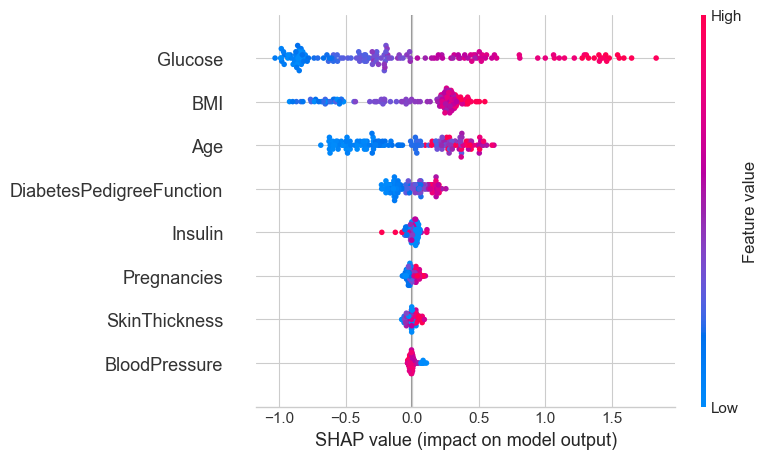

In [43]:
# Shap
explainer_shap = shap.Explainer(models_cls["XGBoost"], X_test_cls)
shap_values = explainer_shap(X_test_cls)

shap.summary_plot(shap_values, X_test_cls, feature_names=X_cls.columns)


100%|██████████| 154/154 [03:36<00:00,  1.41s/it]


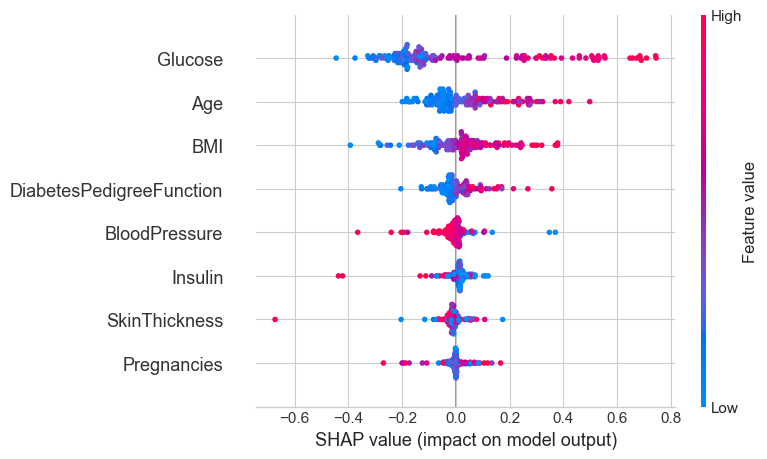

In [47]:
# Shap
explainer = shap.KernelExplainer(models_cls["SVC"].predict, shap.sample(X_train_cls, 100))
shap_values = explainer.shap_values(X_test_cls)
shap.summary_plot(shap_values, X_test_cls, feature_names=X_cls.columns)

100%|██████████| 154/154 [00:28<00:00,  5.45it/s]


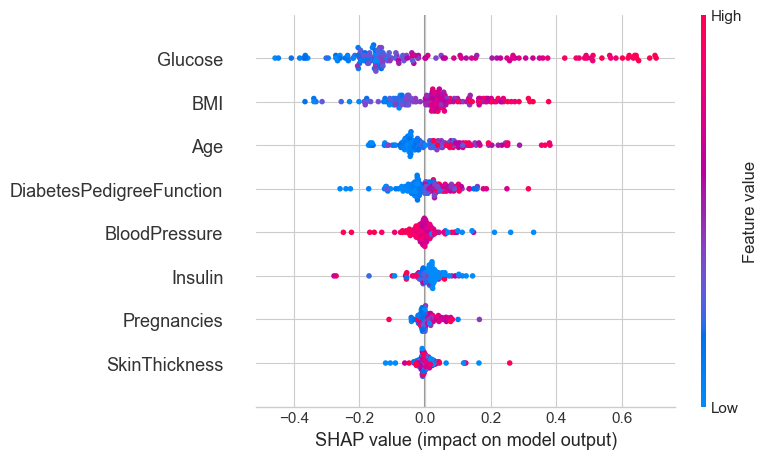

In [48]:
# Shap
explainer = shap.KernelExplainer(models_cls["RandomForest"].predict, shap.sample(X_train_cls, 100))
shap_values = explainer.shap_values(X_test_cls)
shap.summary_plot(shap_values, X_test_cls, feature_names=X_cls.columns)

LIME (Local Interpretable Model-agnostic Explanations)
Tworzy lokalnie wierne uproszczone modele, które są łatwe do zrozumienia, aby wyjasnić poejdyncze predykcje złożonego modelu.
Lokalne metody wyjaśniania koncentrują się na wyjaśnieniu pojedynczych predykcji modelu, pokazując, które cechy przyczyniły się do konkretnej decyzji modelu dla danego przypadku.

Lime dla klasyfikacji:

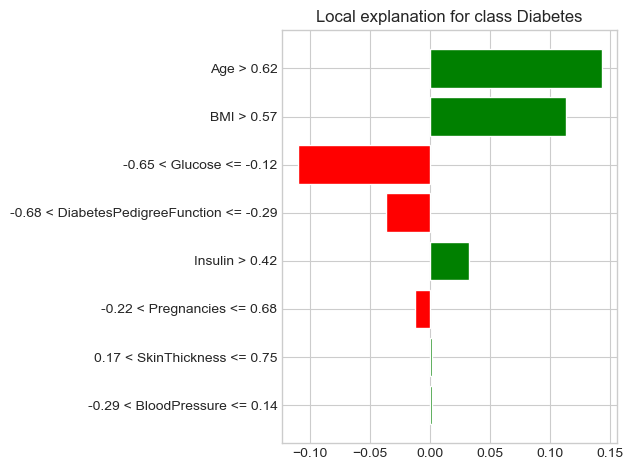

In [69]:
# Lime RandomForest
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train_cls, feature_names=X_cls.columns,
                                class_names=['No Diabetes', 'Diabetes'], discretize_continuous=True)

exp = explainer_lime.explain_instance(X_test_cls[5], models_cls["RandomForest"].predict_proba)


fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

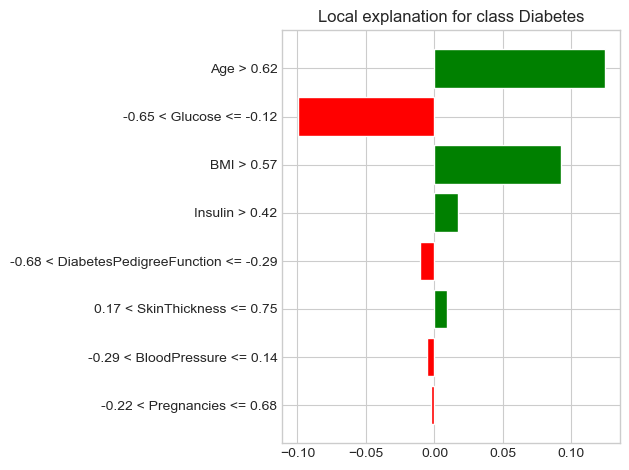

In [70]:
# Lime XGBoost
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train_cls, feature_names=X_cls.columns,
                                class_names=['No Diabetes', 'Diabetes'], discretize_continuous=True)

exp = explainer_lime.explain_instance(X_test_cls[5], models_cls["XGBoost"].predict_proba)


fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

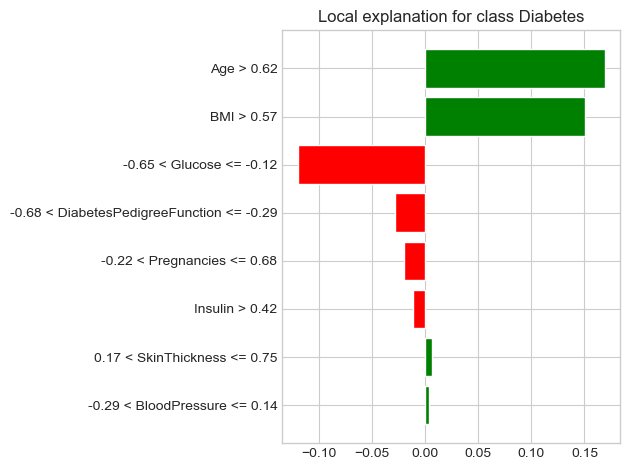

In [71]:
# Lime SVC
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train_cls, feature_names=X_cls.columns,
                                class_names=['No Diabetes', 'Diabetes'], discretize_continuous=True)

exp = explainer_lime.explain_instance(X_test_cls[5], models_cls["SVC"].predict_proba)


fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

Metody wyjaśniania globalnego

Feature importance - to metryka wskazująca, jak duży wpływ poszczególne cechy (kolumny danych wejściowych) mają na decyzję modelu. Innymi słowy — mówi, które zmienne najbardziej pomagają modelowi w przewidywaniu.

Do czego służy?
- Interpretacja działania modelu („na czym się opiera”).
- Usuwanie mało ważnych cech (feature selection).
- Poprawa działania modelu i jego szybkości.
- Wizualizacja istotności cech (łatwiejsze wyjaśnianie modelu).


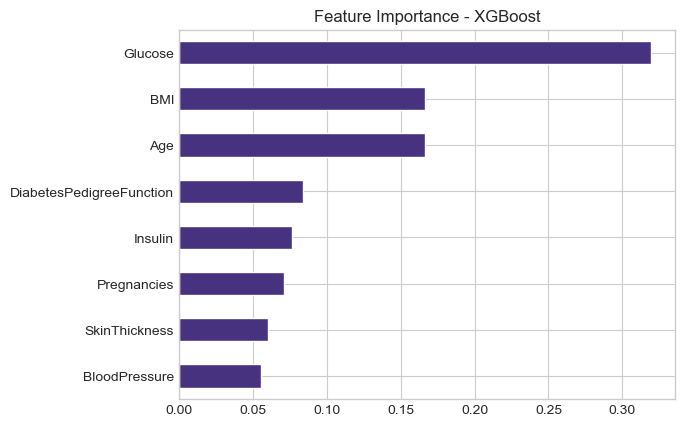

In [73]:
# Feature importance (global)
importances = models_cls["XGBoost"].feature_importances_
feat_importance = pd.Series(importances, index=X_cls.columns)
feat_importance.sort_values().plot(kind="barh", title="Feature Importance - XGBoost")
plt.show()


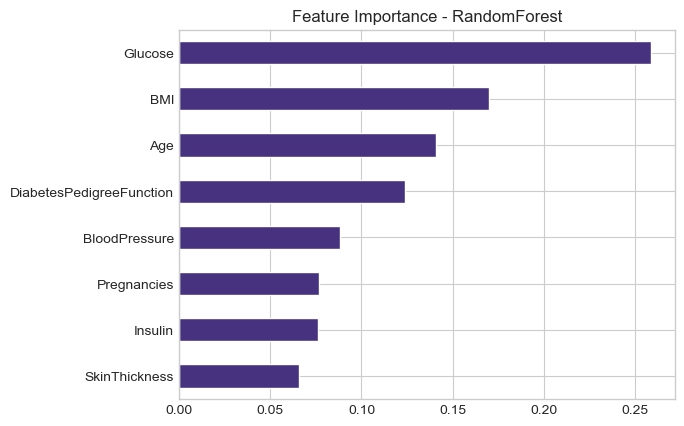

In [74]:
importances = models_cls["RandomForest"].feature_importances_
feat_importance = pd.Series(importances, index=X_cls.columns)
feat_importance.sort_values().plot(kind="barh", title="Feature Importance - RandomForest")
plt.show()

In [77]:
# SVC nie wspiera feature importances


PDP (Partial Dependence Plot) - wykres częściowej zależności, to narzędzie służące do wizualizacji wpływu jednej (lub dwóch) cech na przewidywania modelu ML, przy założeniu, że inne cechy są „zamrożone”.

PDP pozwala odpowiedzieć na pytanie:
Jak zmieniają się przewidywania modelu, gdy zmieniamy wartość konkretnej cechy, a inne zostają bez zmian?

Zastosowania:
- Interpretacja modeli ML (szczególnie drzew, lasów losowych, XGBoost itp.)
- Zrozumienie wpływu cech na wynik regresji lub klasyfikacji
- Analiza nieliniowych zależności między cechami a predykcją
- Weryfikacja, czy model zachowuje się zgodnie z intuicją domenową

uśrednia wpływ cechy, więc nie pokazuje interakcji lokalnych (w przeciwieństwie do SHAP).


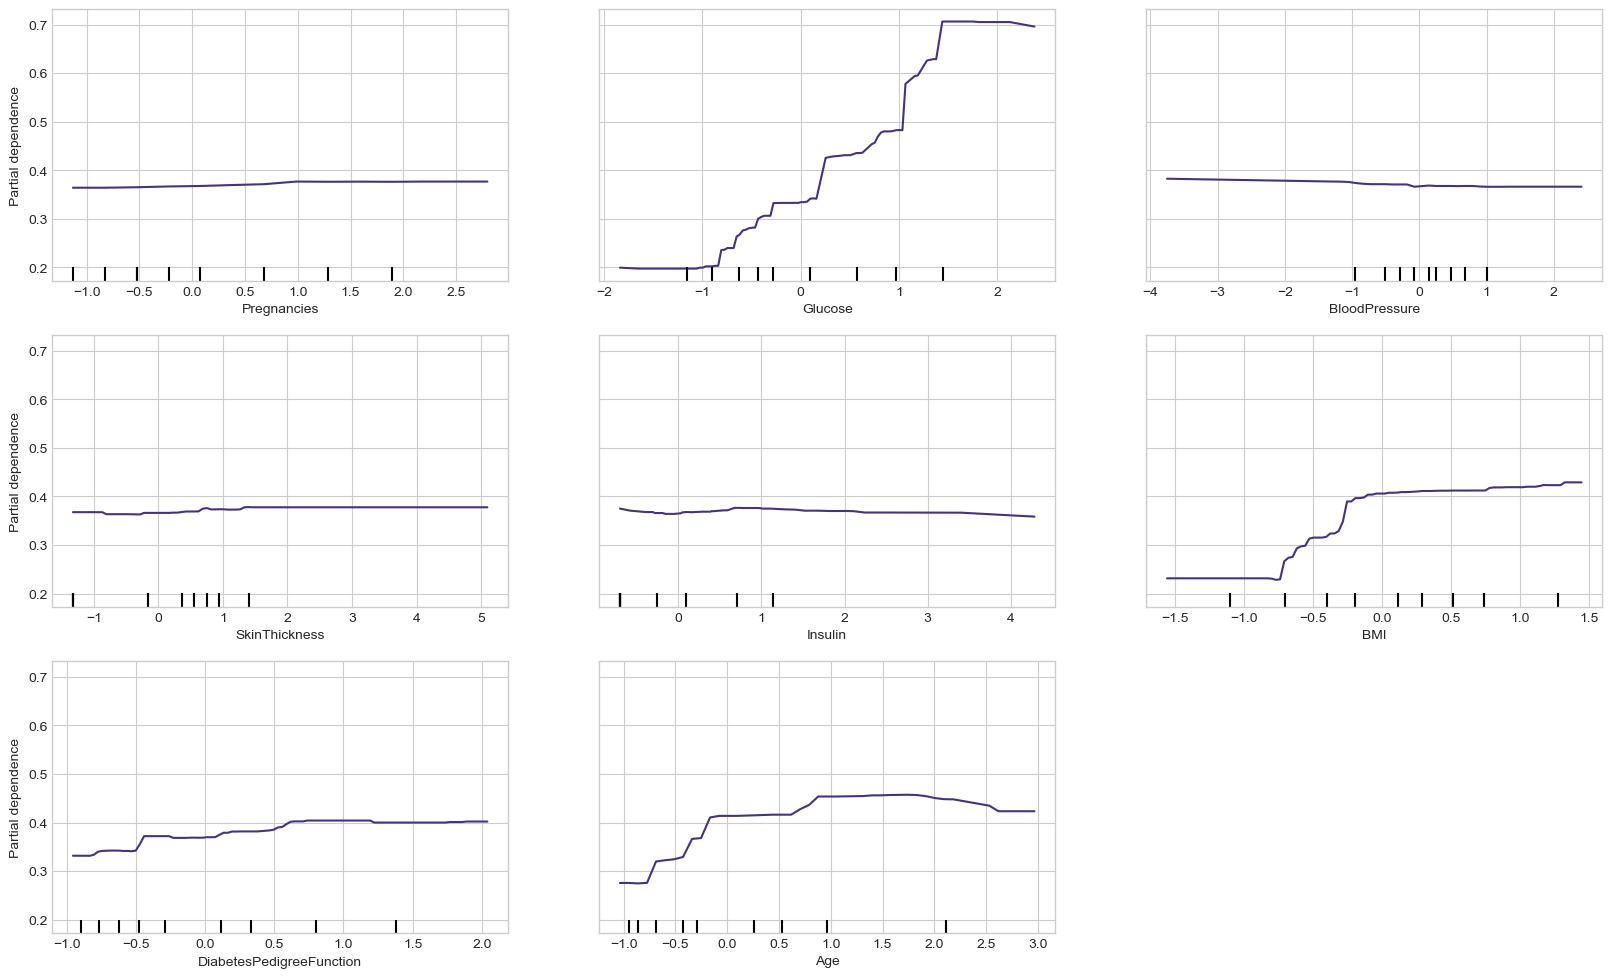

In [101]:
# PDP XGBoost
fig, ax = plt.subplots(figsize=(20, 12))
PartialDependenceDisplay.from_estimator(models_cls["XGBoost"], X_test_cls, X_cls.columns, feature_names=X_cls.columns, ax=ax)
plt.show()

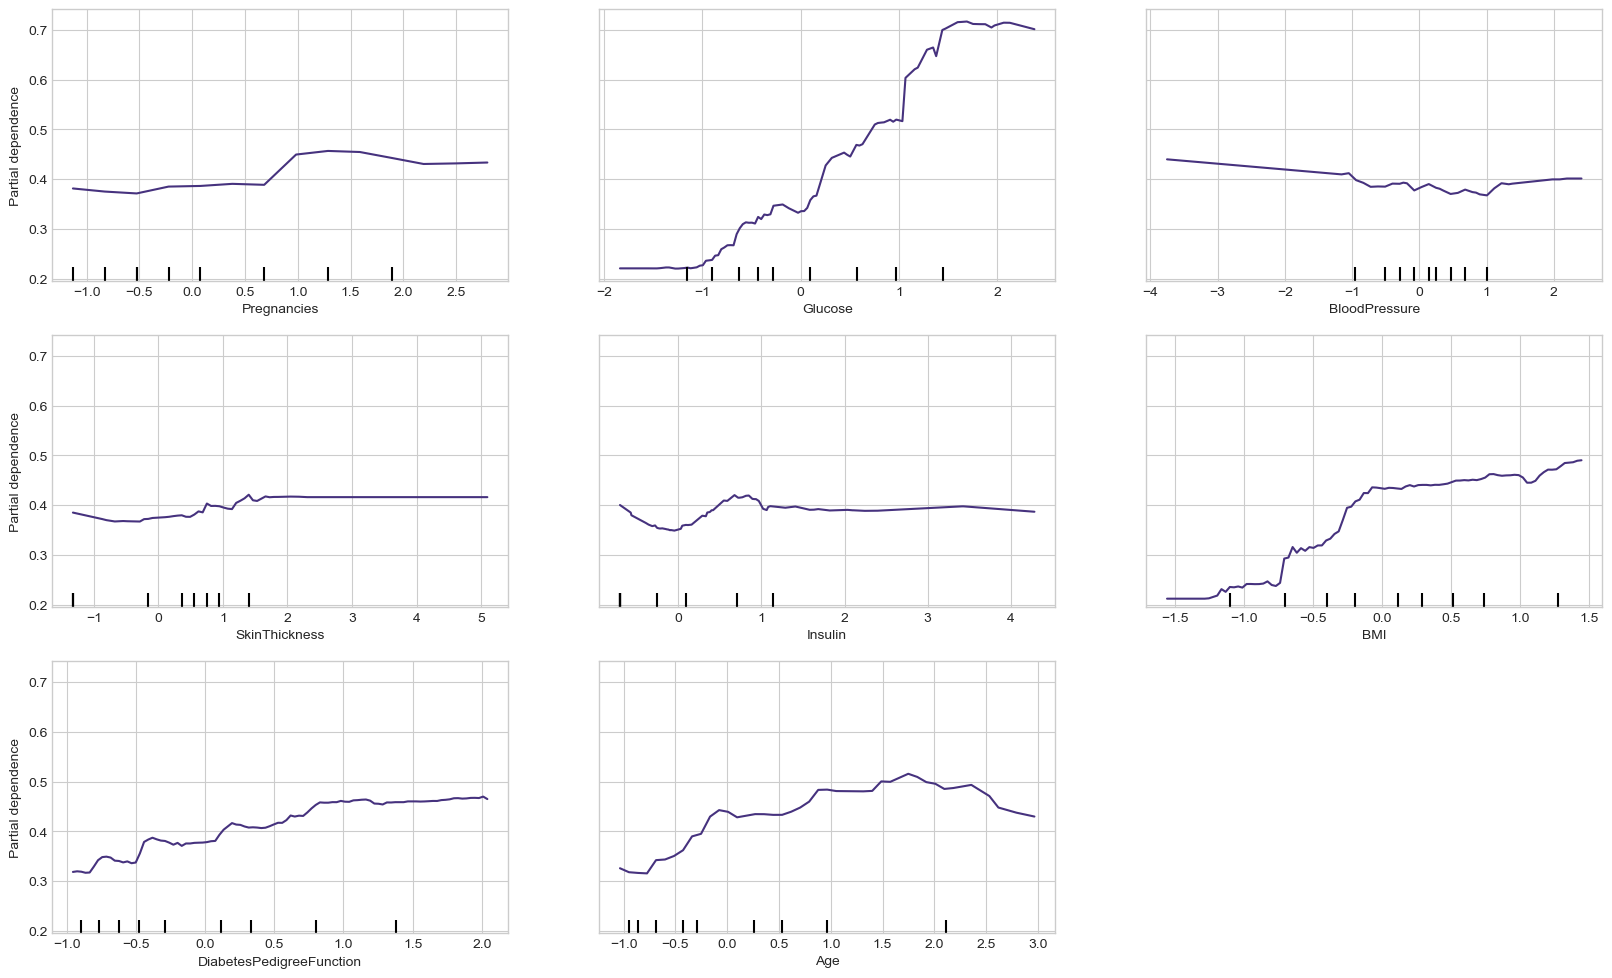

In [104]:
# PDP RandomForest
fig, ax = plt.subplots(figsize=(20, 12))
PartialDependenceDisplay.from_estimator(models_cls["RandomForest"], X_test_cls, X_cls.columns, feature_names=X_cls.columns,ax=ax)
plt.show()

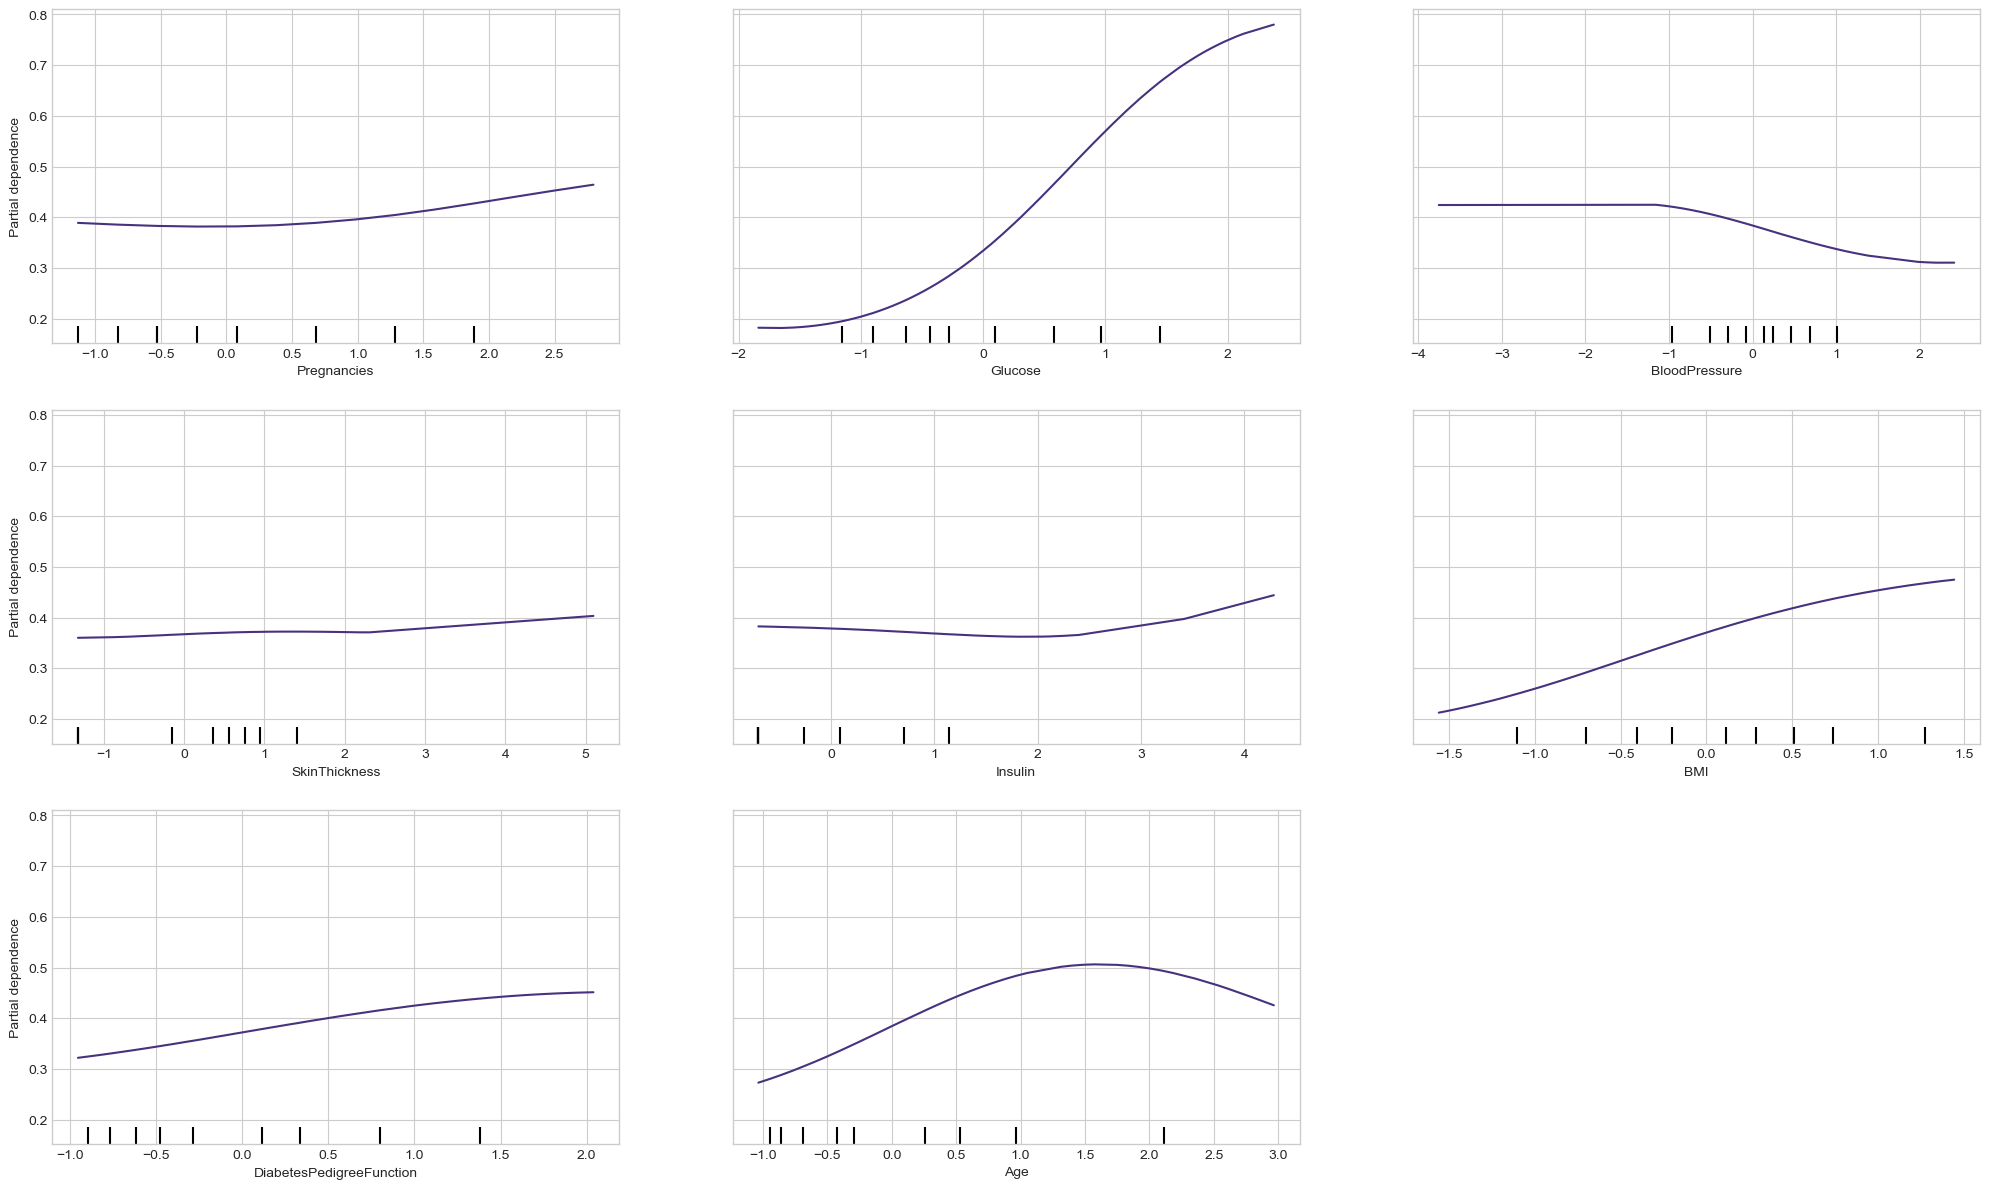

In [105]:
# PDP SVC
fig, ax = plt.subplots(figsize=(20, 12))
PartialDependenceDisplay.from_estimator(models_cls["SVC"], X_test_cls, X_cls.columns, feature_names=X_cls.columns, ax=ax)
plt.tight_layout()
plt.show()




Przygotowanie danych do regresji:

In [49]:

# Regression
data_adverts = pd.read_csv("Walmart_Sales.csv")
data_adverts = data_adverts.drop(columns=["Date"])


X_reg = data_adverts.drop("Weekly_Sales", axis=1)
y_reg = data_adverts["Weekly_Sales"]

# split data set to train/test sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# standarize data
scaler_reg = StandardScaler()
X_train_reg = scaler_reg.fit_transform(X_train_reg)
X_test_reg = scaler_reg.transform(X_test_reg)
data_adverts.head(10)

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,1554806.68,0,46.50,2.625,211.350143,8.106
5,1,1439541.59,0,57.79,2.667,211.380643,8.106
6,1,1472515.79,0,54.58,2.720,211.215635,8.106
7,1,1404429.92,0,51.45,2.732,211.018042,8.106
8,1,1594968.28,0,62.27,2.719,210.820450,7.808
9,1,1545418.53,0,65.86,2.770,210.622857,7.808


In [50]:
print(f"Zbiór danych o sprzedaży w sieci Walmart: {X_reg.shape[0]} próbek, {X_reg.shape[1]} cech.")
print(f"Statystyki sprzedaży w Walmart:\n{y_reg.describe()}")

Zbiór danych o sprzedaży w sieci Walmart: 6435 próbek, 6 cech.
Statystyki sprzedaży w Walmart:
count    6.435000e+03
mean     1.046965e+06
std      5.643666e+05
min      2.099862e+05
25%      5.533501e+05
50%      9.607460e+05
75%      1.420159e+06
max      3.818686e+06
Name: Weekly_Sales, dtype: float64


Trenujemy 3 modele regresji:

- Linear Regression
- Random Forest Regressor
- XGBRegressor

In [51]:
lr = LinearRegression()
lr.fit(X_train_reg, y_train_reg)

rfr = RandomForestRegressor()
rfr.fit(X_train_reg, y_train_reg)

xgbr = XGBRegressor()
xgbr.fit(X_train_reg, y_train_reg)

y_pred_rfr = rfr.predict(X_test_reg)
y_pred_lr = lr.predict(X_test_reg)
y_pred_xgbr = xgbr.predict(X_test_reg)


print(f"Średnia sprzedaż: {y_test_reg.mean():,.2f}")
print(f"Linear Regression")
print(f"MSE: {mean_squared_error(y_test_reg, y_pred_lr):.4f}")
print(f"R^2: {r2_score(y_test_reg, y_pred_lr):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_lr)):.2f}")
print(f"Błąd względny wyniku w stosunku do średniej sprzedaży (%): {np.sqrt(mean_squared_error(y_test_reg, y_pred_lr)) / y_test_reg.mean() * 100:.2f}%\n")


print(f"RF Regression")
print(f"MSE: {mean_squared_error(y_test_reg, y_pred_rfr):.4f}")
print(f"R^2: {r2_score(y_test_reg, y_pred_rfr):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_rfr)):.4f}")
print(f"Błąd względny wyniku w stosunku do średniej sprzedaży (%): {np.sqrt(mean_squared_error(y_test_reg, y_pred_rfr)) / y_test_reg.mean() * 100:.2f}%\n")


print(f"XGB Regression")
print(f"MSE: {mean_squared_error(y_test_reg, y_pred_xgbr):.4f}")
print(f"R^2: {r2_score(y_test_reg, y_pred_xgbr):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_xgbr)):.4f}")
print(f"Błąd względny wyniku w stosunku do średniej sprzedaży (%): {np.sqrt(mean_squared_error(y_test_reg, y_pred_xgbr)) / y_test_reg.mean() * 100:.2f}%\n")

# RMSE pozwola łatwiej interpretować błąd – w tych samych jednostkach co target (Weekly_Sales)
# R² (współczynnik determinacji) mówi, ile wariancji wyjaśnia model
# RMSE i błąd względny pokazują dokładność

print("Bazując na powyższych wynikach odrzucam regresję liniową z dalszej analizy ponieważ model nie osiąga zadowalającego poziomu błędów.")


Średnia sprzedaż: 1,054,838.73
Linear Regression
MSE: 274455221280.6606
R^2: 0.1481
RMSE: 523884.74
Błąd względny wyniku w stosunku do średniej sprzedaży (%): 49.66%

RF Regression
MSE: 21182332168.0462
R^2: 0.9342
RMSE: 145541.5136
Błąd względny wyniku w stosunku do średniej sprzedaży (%): 13.80%

XGB Regression
MSE: 16282804457.9882
R^2: 0.9495
RMSE: 127604.0926
Błąd względny wyniku w stosunku do średniej sprzedaży (%): 12.10%

Bazując na powyższych wynikach odrzucam regresję liniową z dalszej analizy ponieważ model nie osiąga zadowalającego poziomu błędów.


Wyjaśnienia lokalne SHAP dla regresji
- XGBRegressor
- RandomForestRegressor

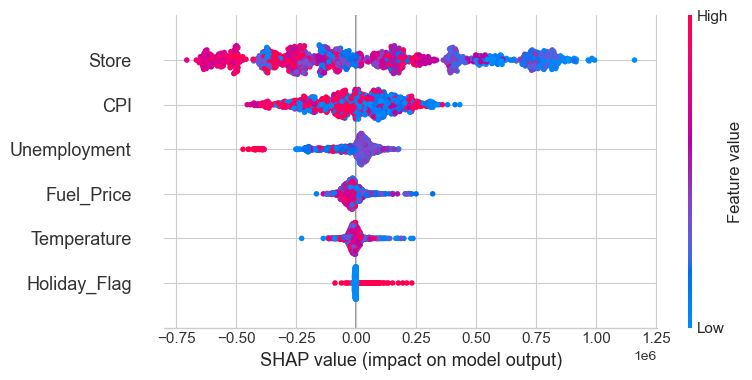

In [54]:
# Shap  XGBRegressor
explainer_shap_reg = shap.Explainer(xgbr, X_train_reg)
shap_values_reg = explainer_shap_reg(X_test_reg)

shap.summary_plot(shap_values_reg, X_test_reg, feature_names=X_reg.columns)


 99%|===================| 1280/1287 [00:51<00:00]        

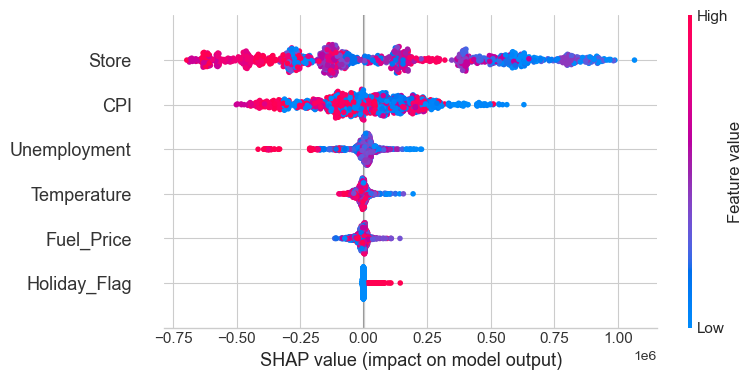

In [56]:
# Shap  RandomForestRegressor
explainer_shap_reg = shap.Explainer(rfr, X_train_reg)
shap_values_reg = explainer_shap_reg(X_test_reg,  check_additivity=False)

shap.summary_plot(shap_values_reg, X_test_reg, feature_names=X_reg.columns)

Wyjaśnienia lokalne LIME dla regresji
- XGBRegressor
- RandomForestRegressor


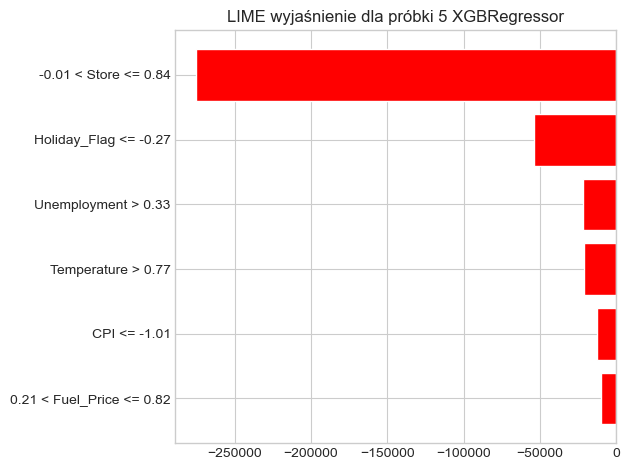

In [62]:
# Lime XGBRegressor
explainer_lime_reg = lime.lime_tabular.LimeTabularExplainer(
    X_train_reg,
    feature_names=X_reg.columns,
    mode="regression")

exp = explainer_lime_reg.explain_instance(X_test_reg[5], xgbr.predict)

fig = exp.as_pyplot_figure()
plt.title("LIME wyjaśnienie dla próbki 5 XGBRegressor")
plt.tight_layout()
plt.show()



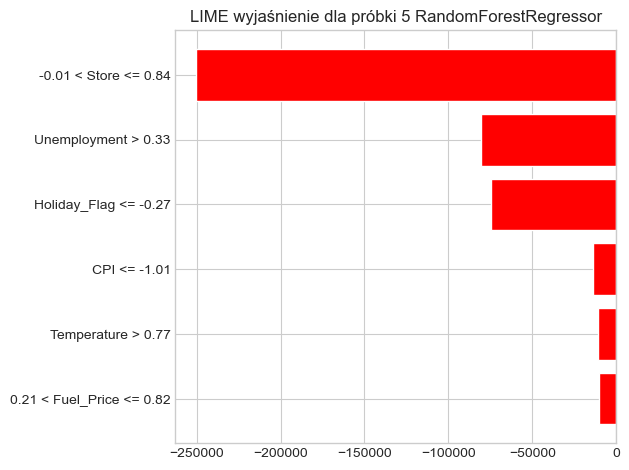

In [64]:
# Lime RandomForestRegressor
explainer_lime_reg = lime.lime_tabular.LimeTabularExplainer(
    X_train_reg,
    feature_names=X_reg.columns,
    mode="regression")

exp = explainer_lime_reg.explain_instance(X_test_reg[5], rfr.predict)

fig = exp.as_pyplot_figure()
plt.title("LIME wyjaśnienie dla próbki 5 RandomForestRegressor")
plt.tight_layout()
plt.show()

Metody wyjaśniania globalnego dla regresji:

Feature importance dla regresji

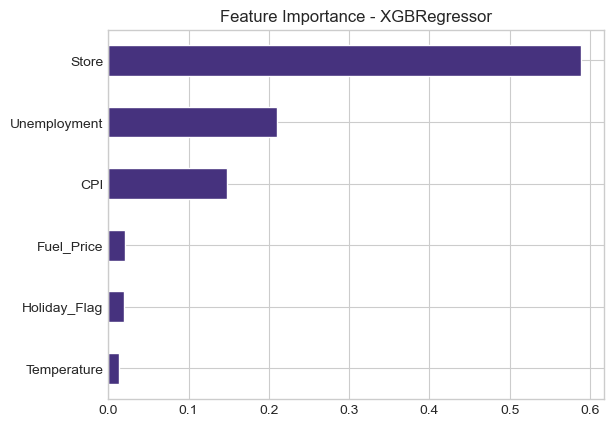

In [89]:
# Feature importance (global) XGBRegressor
importances = xgbr.feature_importances_
feat_importance = pd.Series(importances, index=X_reg.columns)
feat_importance.sort_values().plot(kind="barh", title="Feature Importance - XGBRegressor")
plt.show()

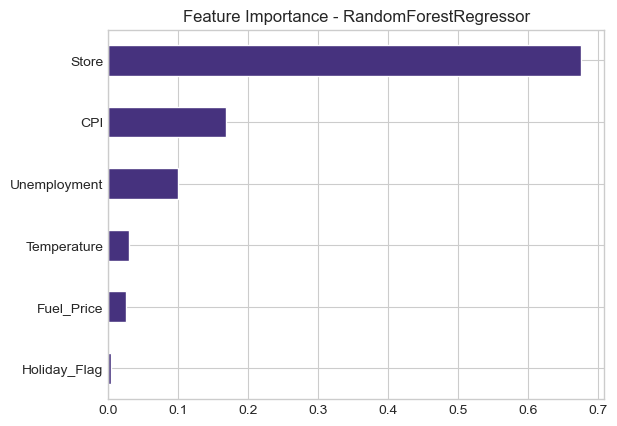

In [91]:
# Feature importance (global) RandomForestRegressor
importances = rfr.feature_importances_
feat_importance = pd.Series(importances, index=X_reg.columns)
feat_importance.sort_values().plot(kind="barh", title="Feature Importance - RandomForestRegressor")
plt.show()


PDP dla regresji

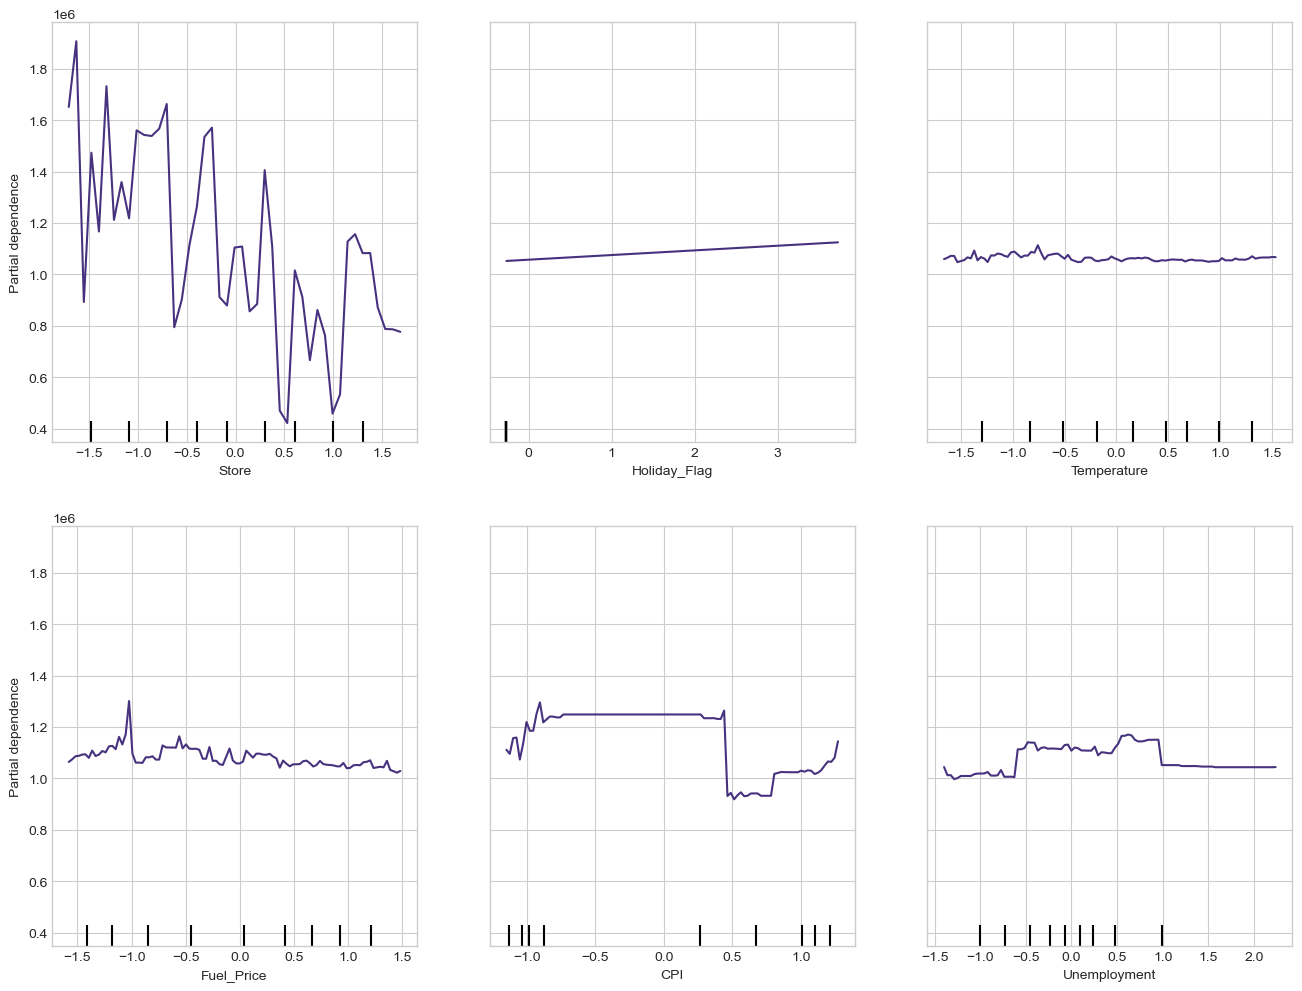

In [106]:
# PDP XGBRegressor
fig, ax = plt.subplots(figsize=(16, 12))
PartialDependenceDisplay.from_estimator(xgbr, X_test_reg, X_reg.columns, feature_names=X_reg.columns, ax=ax)
plt.show()

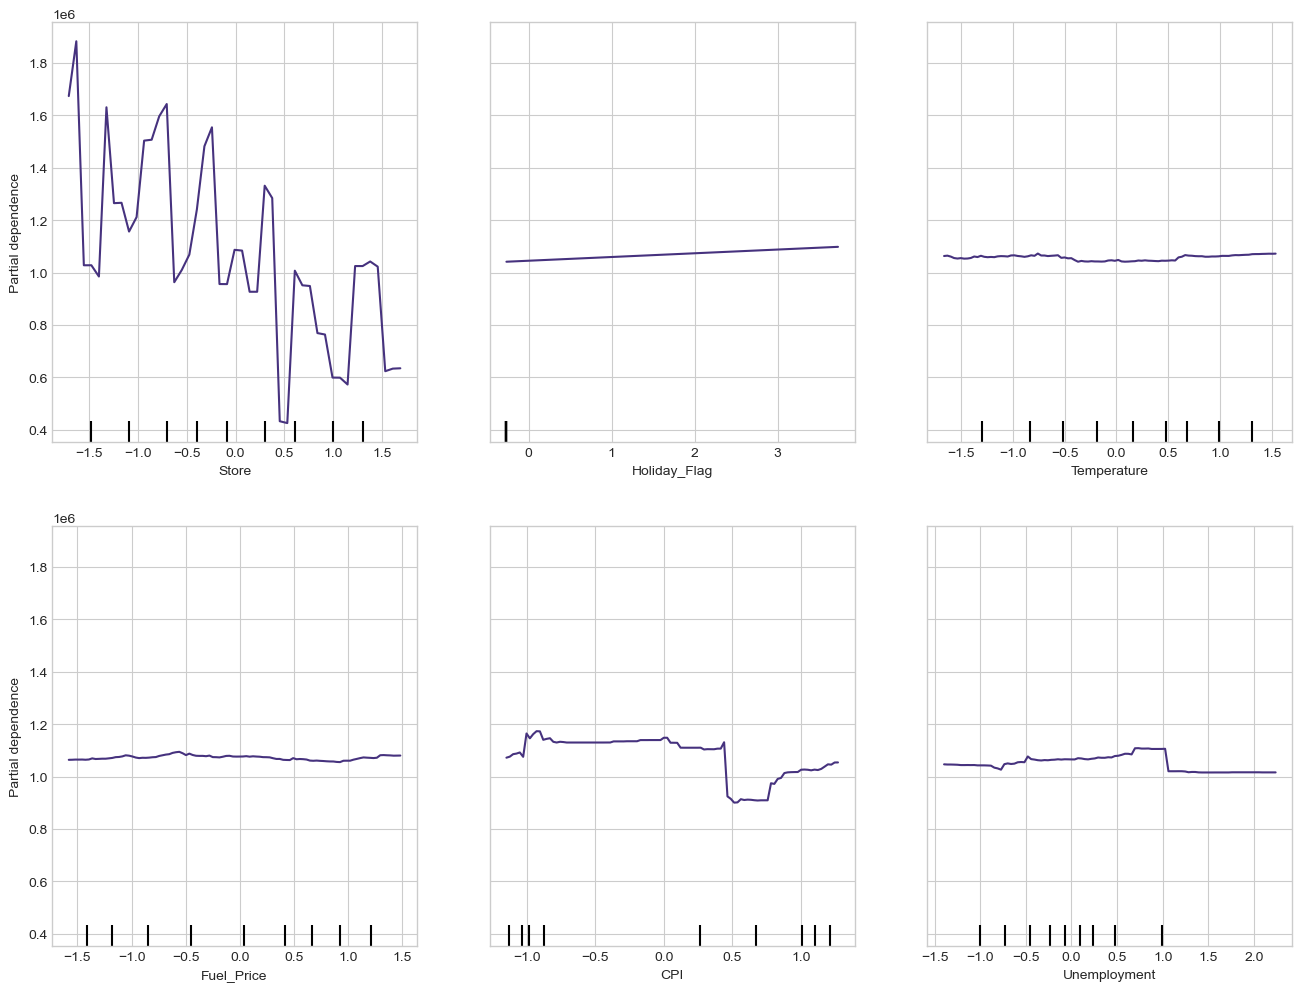

In [107]:
# PDP RandomForestRegressor
fig, ax = plt.subplots(figsize=(16, 12))
PartialDependenceDisplay.from_estimator(rfr, X_test_reg, X_reg.columns, feature_names=X_reg.columns,ax=ax)
plt.show()


Podsumowanie

Do analizy użyłem 2 zbiorów danych:
- Walmart_Sales.csv - do regresji
- diabetes.csv - do klasyfikacji

Stworzyłem 3 modele do klasyfikacji:
- SVC
- RandomForestClassifier
- XGBClassifier

Oraz 3 modele do regresji:
- Linear Regression
- RandomForestRegressor
- XGBRegressor

Model linear regression nie był wykorzystywany w celu pokazania wyjaśnialności ponieważ nie osiągał zadowalających poziomów błędów.

Z modeli klasyfikacji najlepiej wypadł XGBClassifier po  tuningu hiperparametrów za pomocą GridSearchCV, accuracy na poziomie około 0.78
Natomiast w modelach regrasji najlepiej wypada XGBRegressor z R² ~ 0.95 , RMSE ~ 127k oraz Błąd względny ~ 12%.




W zbiorze diabetes dla modeli klasyfikacji SHAP wskazuje na 3 najistotniejsze cechy: Glucose, BMI, Age co pokrywa się z oczekiwaniami co do czynników mających największy wpływa na rozwój cukrzycy.
LIME dla danej próbki również potwierdza te obserwacje.
Feature Importance również wskazuje na ten sam wniosek.
W PDP wyraźnie widać wpływ Gluscose, BMI oraz Age nie wskazuja jednoznacznie na wpływ tych cech na cukrzycę.

Dla zbioru Walmart_Sales dla modeli regresji SHAP wskazuje na: Store, CPI oraz unemployment jako najistotniejsze.
Lime natomiast wskazuje na Store, holiday flag oraz unemployment.
W Feature Importance dostajemy podobny wynik co w SHAP.
PDP nie pozwala jednoznacznie określić cechy która ma największy wpływ poza Store.



Kiedy stosować którą metodę?

- Na początek analizy: Feature importance lub Permutation importance
- Dla zrozumienia charakteru zależności: Partial Dependence Plot
- Dla wyjaśnienia konkretnej predykcji w prostszy sposób: LIME
- Dla dogłębnej analizy wpływu cech na konkretną predykcję: SHAP
- Gdy ważna jest teoretyczna podstawa: SHAP
- Gdy ważna jest szybkość obliczeniowa: LIME lub wbudowane Feature Importance

Najlepsze praktyki:
- Używać wielu metod wyjaśniania aby uzyskać pełniejszy obraz
- Dopasować metodę do potrzeb odbiorcy (techniczny/nietechniczny)
- Pamiętać o ograniczeniach każdej metody
- Zawsze weryfikować wyjaśnienia z wiedzą dziedzinową
- Używać wyjaśnień do iteracyjnego ulepszania modeli

Wyzwania:
- niestabilność wyjaśnień
- trade-off między dokładnością a interpretowalnością
- manipulacja wyjaśnieniami